# COURSEWORK 1

<span style="color: #ffac00; font-weight: bold;">SUBMISSION DEADLINE:</span> Thursday 8 August 6pm. 

Please answer ONE question of your choice, out of the two questions below.
Your answer should be 500 words max (+ code).

- Write your answer directly in markdown cells below, in this notebook.
- Do include simulation code + figures, but do not limit your answer to these; instead, write a _narrative_.
- Make sure to submit a clean notebook; in particular:
   - all cells must have been evaluated without errors; do not “clear outputs” before submitting
   - the whole notebook is *linear*, i.e. can be re-evaluated (e.g. by me!) by only moving forward cell by cell.
   
To submit, download your notebook as an `.ipynb` file, and drag-and-drop your file in a direct message to me on [slack](https://pkp-neuro.slack.com).


Remember: I am on slack to help you with OCaml; don't hesitate to ask me "how do we do this, ..." if you get stuck; I will generally answer, as long as you are not asking for the entire solution to the coursework :)

**117474**

# Question 2

Investigate the response of the HH model, the Connor-Stevens model (a HH-type model with parameters better suited to mammalian cortical neurons; those parameters are called `HH.connor_stevens`), and the LIF model, to oscillating input. Specifically, consider injecting a current of the form

$$ h(t) = a\ \cos (2\pi f t) $$ 

where $f$ is some stimulation frequency (in Hz), and `a=0.1E-9` amperes is small enough that the neuron does not fire action potentials.
Since the input is periodic, so will the output (after some transient). To convince yourself that that's true, begin by looking at the membrane potential response for, say, `f=20.0` Hz.

- In each of the three models, how does the amplitude of the voltage oscillations (peak-to-trough) depend on the stimulation frequency $f$? Comment on any qualitative differences.

Hint: you might want to use `Mat.max'` and `Mat.min'`.

# <span style="color:#C71585;font-weight: bold;">  CODE </span>

In [2]:
;;
#require "pkp"

In [3]:
open Owl

open Gp

open Pkp.Neuron

<span style="color:#C71585;font-weight: bold;">The following function creates a periodic current input with formula :
$ h(t) = a\ \cos (2\pi f t) $,</span>
<span style="color:#C71585;font-weight: bold;"> where:
- <span style="color:#C71585;font-weight: bold;">the amplitude of the sinusoidal current is $a=0.1E-9$ amperes.</span>
- <span style="color:#C71585;font-weight: bold;">the frequency of the input is a variable represented by f.</span>
- <span style="color:#C71585;font-weight: bold;">time is represented by t.</span>

In [4]:
let a = 0.1E-9

let h f t = a *. cos (2. *. Float.pi *. f *. t)

val a : float = 1e-10


val h : float -> float -> float = <fun>


<span style="color:#C71585;font-weight: bold;"> We verify that a periodic input results in a periodic output by plotting the membrane potential response as a function of time for one instance: $f=10Hz$ in the HH model </span>.

In [5]:
(* Simulate with HH *)
let time_test, state_test = HH.simulate ~prms:HH.default_prms ~duration:2. (h 10.)

val time_test : Owl.Mat.mat =
  
                 C0 
     R0 5.92189E-14 
     R1       1E-05 
     R2       2E-05 
     R3       3E-05 
     R4       4E-05 
                ... 
R199996     1.99996 
R199997     1.99997 
R199998     1.99998 
R199999     1.99999 
R200000           2 

val state_test : Owl.Mat.mat =
  
              C0        C1       C2       C3 
     R0 -70.1352 0.0519878 0.601562 0.315292 
     R1 -70.1255 0.0519971  0.60156 0.315293 
     R2 -70.1157 0.0520064 0.601558 0.315294 
     R3 -70.1061 0.0520199 0.601556 0.315296 
     R4 -70.0966 0.0520373 0.601552 0.315298 
             ...       ...      ...      ... 
R199996 -69.2942 0.0575186 0.575077  0.32809 
R199997 -69.2943 0.0575178 0.575072  0.32809 
R199998 -69.2944  0.057517 0.575068 0.328091 
R199999 -69.2945 0.0575162 0.575063 0.328092 
R200000 -69.2947 0.0575154 0.575059 0.328093 



val plot : Owl.Mat.mat * Owl.Mat.mat -> unit = <fun>


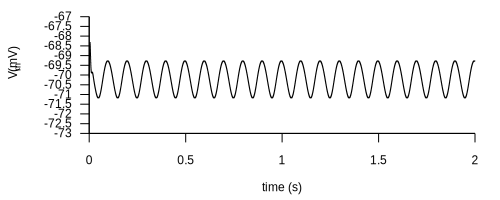

- : unit = ()


In [20]:
(* Plot*)
let plot (time, state) =
  let figure (module P : Plot) =
    P.plot
      (L [ time; state ])
      ~using:"1:2"
      ~style:"l lc 8"
      (default_props
      @ [ xlabel "time (s)"
        ; yrange (-73., -67.)
        ; xrange (0., 2.)
        ; ytics (`regular [ -100.; 0.5 ])
        ; ylabel "V_m (mV)"
        ])
  in
  Juplot.draw ~size:(500, 200) figure
  
let _ = plot (time_test, state_test)

<span style="color:#C71585;font-weight: bold;"> The goal is to investigate the dependence of voltage amplitude on input current frequency for all of the 3 models. </span>
    
<span style="color:#C71585;font-weight: bold;">Simulations based on three models are generated, where </span>
- <span style="color:#C71585;font-weight: bold;"> A total of 150 input frequencies are used and varied on an interval of 1 to 200 </span>
- <span style="color:#C71585;font-weight: bold;"> Simulations of 1.1 seconds are generated. It has been verified that 1.1 seconds is long enough to capture the minimum and maximum for the range of frequency specified. </span> 
- <span style="color:#C71585;font-weight: bold;"> 0.1 seconds of data is discarded in the beginning where there is some irregular fluctration. Thus, the maximum and minimum value will be representative of the steady state. </span>

<span style="color:#C71585;font-weight: bold;">Then, The amplitude V.S. frequency relationship for the 3 models will be plotted on the same diagram for further analysis. </span>

<span style="color:#DB7093;font-weight: bold;"> 1) 
Firstly, we define a function that takes an input for frequency and outputs the amplitude.
The model to be used in simulation can be specified with string input "hh", "cs", or "lif" </span>

In [6]:
let amp model f =
  (*simulate based on the specified model*)
  (*slice to keep only the first column with the voltage data*)
  (*slice in the time axis to avoid the initial irregularity*)
  let voltage =
    match model with
    | "hh" ->
      let time, state = HH.simulate ~prms:HH.default_prms ~duration:1.1 (h f) in
      Mat.get_slice [ [ 10000; 110000 ]; [ 0; 0 ] ] state
    | "lif" ->
      let time, state = LIF.simulate ~prms:LIF.default_prms ~duration:1.1 (h f) in
      Mat.get_slice [ [ 1000; 10999 ]; [] ] state
    | "cs" ->
      let time, state = HH.simulate ~prms:HH.connor_stevens ~duration:1.1 (h f) in
      Mat.get_slice [ [ 10000; 110000 ]; [ 0; 0 ] ] state
    | x -> failwith "Wrong model name."
    (*return error message if input isn't the above three.*)
  in
  let max =
    let i = Mat.max ~axis:0 voltage in
    Mat.get i 0 0
  in
  let min =
    let i = Mat.min ~axis:0 voltage in
    Mat.get i 0 0
  in
  (*Compute the amplitude, which is: half of the difference between max and min*)
  (max -. min) /. 2.

val amp : string -> float -> float = <fun>


 <span style="color:#DB7093;font-weight: bold;"> 2) 
Now we define a matrix for the input frequencies, and then map it to the function we have defined 
in order to generate three matrices for the corresponding amplitudes predicted by the three models: hh, lif and cs. </span>

In [7]:
(*frequency matrix*)
let freq = Mat.linspace 1. 200. 150

(*hh model*)
let amp_hh = Mat.map (amp "hh") freq

(*connor stevens model*)
let amp_cs = Mat.map (amp "cs") freq

(*LIF model*)
let amp_lif = Mat.map (amp "lif") freq

val freq : Owl.Mat.mat =
  
   C0      C1      C2      C3      C4        C145    C146    C147    C148 C149 
R0  1 2.33557 3.67114 5.00671 6.34228 ... 194.658 195.993 197.329 198.664  200 



val amp_hh : Owl.Mat.mat =
  
         C0       C1       C2       C3       C4         C145     C146    C147     C148     C149 
R0 0.885987 0.889134 0.894694 0.902871 0.913019 ... 0.822401 0.813335 0.81116 0.806562 0.796034 



val amp_cs : Owl.Mat.mat =
  
         C0       C1       C2       C3       C4         C145     C146   C147     C148     C149 
R0 0.555866 0.554967 0.553372 0.551118 0.548254 ... 0.347083 0.347752 0.3464 0.346625 0.345792 



val amp_lif : Owl.Mat.mat =
  
        C0      C1      C2     C3      C4         C145    C146     C147     C148    C149 
R0 3.33262 3.32947 3.32382 3.3157 3.30517 ... 0.806028 0.80086 0.795756 0.790715 0.78566 



<span style="color:#DB7093;font-weight: bold;"> 3) 
Finally, we plot the three amplitude V.S. frequency relationship on the same plot
for analysis. </span>

val amp_plot :
  Owl.Mat.mat -> Owl.Mat.mat -> Owl.Mat.mat -> Owl.Mat.mat -> unit = <fun>


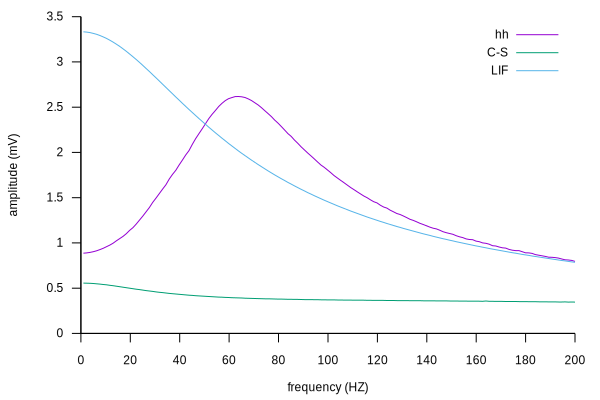

- : unit = ()


In [8]:
(* My plot_all function modified for this question *)
(* automatic ranges *)

let amp_plot frequency ampHH ampCS ampLIF =
  let figure (module P : Plot) =
    P.plots
      [ item (L [ frequency; ampHH ]) ~using:"1:2" ~style:"l lc 1" ~legend:"hh"
      ; item (L [ frequency; ampCS ]) ~using:"1:2" ~style:"l lc 2" ~legend:"C-S"
      ; item (L [ frequency; ampLIF ]) ~using:"1:2" ~style:"l lc 3" ~legend:"LIF"
      ]
      (default_props
      @ [ xlabel "frequency (HZ)"
        ; ytics `auto
        ; ylabel "amplitude (mV)"
        ])
  in
  Juplot.draw ~size:(600, 400) figure

let _ = amp_plot freq amp_hh amp_cs amp_lif

<span style="color:#DB7093;font-weight: bold;"> 4) 
An additional trial is run in order to survey a larger domain of frequency. </span>

val freq : Owl.Mat.mat =
  
   C0      C1      C2      C3      C4         C95     C96     C97     C98  C99 
R0  1 11.0909 21.1818 31.2727 41.3636 ... 959.636 969.727 979.818 989.909 1000 



val amp_cs : Owl.Mat.mat =
  
         C0       C1       C2       C3       C4          C95      C96      C97      C98      C99 
R0 0.555866 0.534037 0.493799 0.456125 0.427745 ... 0.161741 0.160841 0.159519 0.158161 0.157365 



val amp_lif : Owl.Mat.mat =
  
        C0      C1      C2      C3      C4          C95     C96      C97      C98      C99 
R0 3.33262 3.24938 3.05451 2.80111 2.53579 ... 0.170748 0.16903 0.167348 0.165701 0.163907 



val amp_plot :
  Owl.Mat.mat -> Owl.Mat.mat -> Owl.Mat.mat -> Owl.Mat.mat -> unit = <fun>


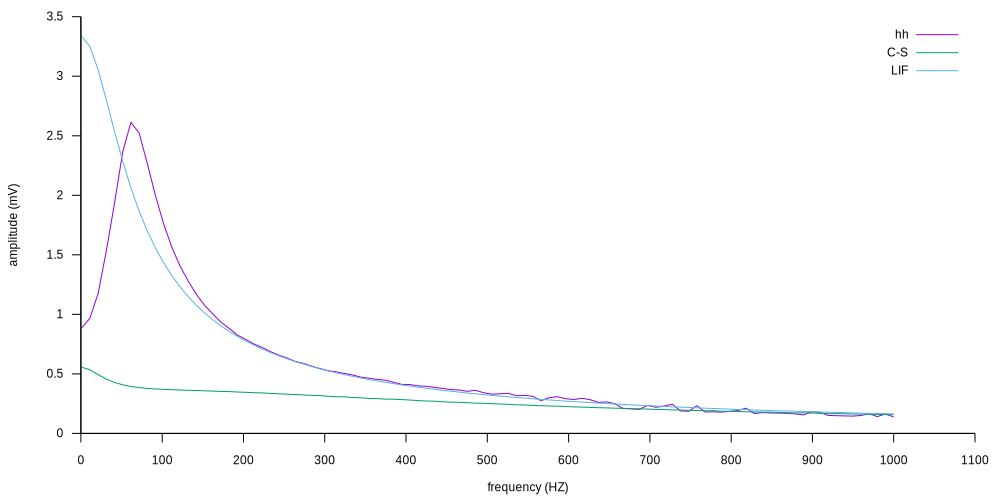

- : unit = ()


In [9]:
(*frequency matrix*)
let freq = Mat.linspace 1. 1000. 100

(*hh model*)
let amp_hh = Mat.map (amp "hh") freq

(*connor stevens model*)
let amp_cs = Mat.map (amp "cs") freq

(*LIF model*)
let amp_lif = Mat.map (amp "lif") freq

(* My plot_all function modified for this question *)
(* automatic ranges *)

let amp_plot frequency ampHH ampCS ampLIF =
  let figure (module P : Plot) =
    P.plots
      [ item (L [ frequency; ampHH ]) ~using:"1:2" ~style:"l lc 1" ~legend:"hh"
      ; item (L [ frequency; ampCS ]) ~using:"1:2" ~style:"l lc 2" ~legend:"C-S"
      ; item (L [ frequency; ampLIF ]) ~using:"1:2" ~style:"l lc 3" ~legend:"LIF"
      ]
      (default_props
      @ [ xlabel "frequency (HZ)"
        ; ytics `auto
        ; ylabel "amplitude (mV)"
        ])
  in
  Juplot.draw ~size:(1000, 500) figure

let _ = amp_plot freq amp_hh amp_cs amp_lif

# <span style="color:#C71585;font-weight: bold;">  OBSERVATIONS </span>

The LIF model predicts a strong negative correlation between amplitude and frequency, with a curve that resembles an exponential decay. 

In the Connor-Stevens model, amplitude is almost unrelated to frequency. The second plot reveals a very minimal reduction. This model also predicts the lowest amplitude.

Hodgkin-Huxley model shows a relatively complex dependence of amplitude on frequency, where amplitude initially increases, reaches a magnitude at around 60Hz, and then declines in a manner similar to LIF.

The predictions of LIF and Hodgkin-Huxley converge at around 200 HZ and the predictions of all three models converged at around 700 Hz.

# <span style="color:#C71585;font-weight: bold;"> ANALYSIS </span>

I will explain the varying amplitude predictions of each model by considering the behavior of the channel gate activations.

Firstly, we notice a general decrease in amplitude as frequency increases. This is because the state of the channel gates are time dependent. A higher current frequency causes the current to fluctruate rapidly. As a result, there is less time for the gates to "react" and less change in their states. Since membrane potential is stimulated by the state of the gates, there is thus less fluctruation in membrane potential--in other words, the amplitude is lower. 

Now, the difference between the predictions made by HH model and LIF model is due to the fact that: HH model has three gates: activation gates n and m, and inactivation gate h, while LIF is simplified and has only one activation gate. 
- Since LIF has no inactivation gate, the membrane potential will keep increasing as long as the gate is open. We also know how long the gate is open depends how long a certain magnitude of current is supplied. Consequently, the higher the current frequency, the less time the current magnitude is high enough for the gate to remain open, and thus we observe a shorter spike--a lower amplitude. 
- The complexity of the HH model is a result of the compound effect of the three gates. 
    - The inactivation gate h supresses the amplitude because h gate remains closed in a refractory period after being activated. This mechanism makes it harder for the neuron to fire after it has already fired. (In fact, this is why we only observe an initial action potential in the simulations and the neuron never fired again)
    - The effect of h gate is pronounce in the lower frequency range because h has the slowest reaction out of the three gates. This is also obvious from the formula: h scales to $t$, while n scales to $t^4$ and m scales to $t^3$. However, in high frequencies, h gate has less effect because there the current oscillate too fast for it to change its state. Thus, in the high frequency domain, the HH model essentially has only activation gates (same as LIF), which explains why its predictions converge with that of the LIF model.
    
Finally, Connor Stevens model differ from HH model by an additional transient potassium current, called A current, which has an activation gate $\alpha$ and an inactivation gate $\beta$. As a net result, the state of the gates do not fluctruate much at all. Connor Stevens model is successful in explaining why some neurons remain stable and refrain from repetitive firing. the properties of the Connor Stevens model is clearly visible on the nearly flat curve.
(Reference: https://core.ac.uk/download/pdf/82423865.pdf and pkp documentation.)

Below is one additional graph that shows the minimal variation in the state of gate for the Connor Stevens model.

In [6]:
(* Simulate with Connor Stevens *)
let time_cs, state_cs = HH.simulate ~prms:HH.connor_stevens ~duration:2. (h 10.)

val time_cs : Owl.Mat.mat =
  
                 C0 
     R0 5.92189E-14 
     R1       1E-05 
     R2       2E-05 
     R3       3E-05 
     R4       4E-05 
                ... 
R199996     1.99996 
R199997     1.99997 
R199998     1.99998 
R199999     1.99999 
R200000           2 

val state_cs : Owl.Mat.mat =
  
              C0        C1       C2       C3       C4       C5 
     R0 -67.9741 0.0100704 0.965914 0.155856 0.540423 0.288666 
     R1 -67.9643 0.0100735 0.965914 0.155857 0.540423 0.288666 
     R2 -67.9549 0.0100806 0.965913 0.155858 0.540424 0.288664 
     R3 -67.9457 0.0100895 0.965912 0.155859 0.540426 0.288662 
     R4 -67.9368 0.0100983  0.96591  0.15586 0.540428 0.288659 
             ...       ...      ...      ...      ...      ... 
R199996  -67.432 0.0108119 0.963185 0.161305 0.543166 0.277966 
R199997 -67.4319 0.0108122 0.963185 0.161306 0.543166 0.277964 
R199998 -67.4319 0.0108126 0.963184 0.161307 0.543167 0.277961 
R199999 -67.4318  0.010813 0.963184 0.161309

In [7]:
let my_plot_all (time, state)  =
  let figure (module P : Plot) =
    P.plot
      (L [ time; state ])
      ~using:"1:2"
      ~style:"l lc 8"
      (default_props
      @ [ margins [ `top 0.95; `bottom 0.5 ]
        ; xlabel "time (s)"
        ; ytics (`regular [ -100.; 0.5 ])
        ; ylabel "V_m (mV)"
        ]);
    P.plots
      [ item (L [ time; state ]) ~using:"1:3" ~style:"l lc 1" ~legend:"M"
      ; item (L [ time; state ]) ~using:"1:4" ~style:"l lc 2" ~legend:"H"
      ; item (L [ time; state ]) ~using:"1:5" ~style:"l lc 3" ~legend:"N"
      ]
      (default_props
      @ [ margins [ `top 0.4; `bottom 0.1 ]
        ; xlabel "time (s)"
        ; ytics `auto
        ; ylabel "gates"
        ])
  in
  Juplot.draw ~size:(600, 500) figure

val my_plot_all : Owl.Mat.mat * Owl.Mat.mat -> unit = <fun>


In [23]:
let _ = my_plot_all (time_cs, state_cs)

- : unit = ()
